In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import sys; sys.path.append('/home/ubuntu/EFAAR_benchmarking')
import efaar_benchmarking 

EGFR_inhibitors = [
    'neratinib', 'gefitinib', 'lapatinib', 
    'afatinib', 'icotinib', 'vandetanib', 
    'olmutinib', 'azd9291', 'erlotinib', 
    'osi-420', 'dacomitinib'
]

In [3]:
import anndata as ad
rxrx3_adata = ad.read_h5ad('../data/rxrx3.h5ad')
rxrx3_adata.obs_names = rxrx3_adata.obs['well_id']

In [4]:
import matplotlib
# matplotlib.use('Agg')  # or another backend you prefer
from efaar_benchmarking.data_loading import load_rxrx3
features, metadata = load_rxrx3('../data')
features.head(1)
metadata.head(1)

/home/ubuntu/EFAAR_benchmarking/efaar_benchmarking/data_loading.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["gene"] = metadata["treatment"].apply(lambda x: x.split("_")[0] if "_control" not in x else x)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,-0.935309,-0.3275,-0.898324,0.078159,-0.871174,0.090497,-2.274602,-0.142285,0.883039,1.102315,...,0.076941,-0.023445,-0.564273,-1.03212,-0.158012,-0.294054,0.370236,-0.266981,1.190528,1.153945


,experiment_name,plate,gene
0,compound-001,1,EMPTY_control


# Get the EGFR inhibitors

In [179]:
rxrx3_adata_compound = rxrx3_adata[rxrx3_adata.obs['perturbation_type'] == 'COMPOUND', :]
EGFR_inhibitor_adata = rxrx3_adata_compound[rxrx3_adata_compound.obs['treatment'].str.lower().isin(EGFR_inhibitors + ['empty_control', 'crispr_control']), :].copy()
EGFR_inhibitor_adata.obs['treatment_conc'] = EGFR_inhibitor_adata.obs['treatment'].str.lower() + '_' + EGFR_inhibitor_adata.obs['concentration'].astype(str)
EGFR_inhibitor_adata.to_df().head(1)
EGFR_inhibitor_adata.obs.head(1)
EGFR_inhibitor_adata.shape

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
well_id,,,,,,,,,,,,,,,,,,,,,
compound-001_11_U08,0.237343,-1.785078,-1.506901,2.627998,-0.172389,0.859348,-0.933236,0.349534,2.334168,-1.204702,...,-2.159524,-0.405164,0.287165,0.72411,-0.794379,0.692088,0.694725,-0.426479,2.43266,-1.714991


,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type,treatment_conc
well_id,,,,,,,,,,,
compound-001_11_U08,compound-001_11_U08,compound-001,11,U08,NaN,EMPTY_control,NaN,NaN,COMPOUND,HUVEC,empty_control_nan


(32648, 128)

In [149]:
def groupby_mean_adata(adata, groupby_col):
    # groupby the column in adata.obs and compute the mean for each group
    grouped = adata.to_df().groupby(adata.obs[groupby_col]).mean()
    
    # create a new AnnData object with the grouped data
    new_adata = ad.AnnData(X=grouped.values)
    
    # set the obs index to the groupby index
    new_adata.obs[groupby_col] = grouped.index
    
    # set var names to the original var names
    new_adata.var_names = adata.var_names
    
    return new_adata

In [ ]:
EGFR_inhibitor_adata_mean = groupby_mean_adata(EGFR_inhibitor_adata, 'treatment_conc')
EGFR_inhibitor_adata_mean.obs_names = EGFR_inhibitor_adata_mean.obs['treatment_conc']
EGFR_inhibitor_adata_mean.to_df()

In [128]:
EGFR_inhibitor_adata[EGFR_inhibitor_adata.obs['treatment'] == 'EMPTY_control', :].obs

,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type,treatment_conc
well_id,,,,,,,,,,,


# Get the EGFR KO

In [6]:
EGFR_ko_adata = rxrx3_adata[rxrx3_adata.obs['gene'].isin(['EGFR']), :].copy()
EGFR_ko_adata.to_df().head(1)
EGFR_ko_adata.obs.head(1)
EGFR_ko_adata.shape


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
well_id,,,,,,,,,,,,,,,,,,,,,
gene-081_5_B14,-0.09579,-0.573949,0.347614,0.032644,-0.357747,-2.877236,1.420335,-1.601538,-0.336809,-0.084155,...,-0.661021,-3.02133,-1.35916,1.482987,-0.796966,0.754805,1.692366,-0.539705,0.991521,0.46364


,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type
well_id,,,,,,,,,,
gene-081_5_B14,gene-081_5_B14,gene-081,5,B14,EGFR,EGFR_guide_3,NaN,NaN,CRISPR,HUVEC


(105, 128)

# Get the named genes

In [116]:
import numpy as np
ko_mask = (rxrx3_adata.obs['perturbation_type'] == 'CRISPR')
named_gene_mask = ko_mask & (~rxrx3_adata.obs['gene'].str.contains('RXRX').replace(np.nan, True))

rxrx3_adata_named_genes = rxrx3_adata[ko_mask & named_gene_mask, :]
rxrx3_adata_named_genes.obs.head(1)

/tmp/ipykernel_969402/1086281894.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  named_gene_mask = ko_mask & (~rxrx3_adata.obs['gene'].str.contains('RXRX').replace(np.nan, True))


,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type
well_id,,,,,,,,,,
gene-060_9_P28,gene-060_9_P28,gene-060,9,P28,EMPTY_control,EMPTY_control,NaN,NaN,CRISPR,HUVEC


In [151]:
rxrx3_adata_named_genes_mean = groupby_mean_adata(rxrx3_adata_named_genes, 'gene')
rxrx3_adata_named_genes_mean.obs_names = rxrx3_adata_named_genes_mean.obs['gene']
rxrx3_adata_named_genes_mean.to_df()


/tmp/ipykernel_969402/3850581005.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.to_df().groupby(adata.obs[groupby_col]).mean()
/home/ubuntu/morphologic/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:821: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['ABCC1', 'ABCC4', 'ABCC8', 'ABCG2', 'ABL1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
gene,,,,,,,,,,,,,,,,,,,,,
ABCC1,0.321434,0.073349,-0.221614,-0.290375,-0.003343,0.027169,-0.230073,-0.206191,0.191420,0.039421,...,0.142009,-0.241484,0.133916,-0.247923,0.198029,0.189995,-0.079611,-0.070710,-0.075719,0.080359
ABCC4,0.232544,0.161616,-0.186420,-0.022335,-0.072182,0.067631,-0.142412,0.036014,0.100509,-0.005012,...,0.172581,-0.226683,0.065443,-0.025801,-0.029835,0.156834,0.078130,-0.082221,-0.124270,-0.030212
ABCC8,0.170791,0.030170,-0.170498,-0.302961,0.072636,-0.020537,-0.191467,-0.170900,0.171777,0.067048,...,0.164635,-0.001499,0.142864,-0.320860,0.270054,0.131839,-0.035751,-0.188246,-0.073634,0.042702
ABCG2,0.094233,0.099495,-0.052370,-0.437244,0.142597,0.115031,-0.045516,-0.097553,0.129093,-0.139682,...,-0.011513,-0.139585,0.183510,-0.336266,0.040897,0.227552,-0.069348,-0.188858,0.017185,0.062271
ABL1,0.004824,0.156455,-0.161071,-0.605499,0.116255,-0.039449,-0.345538,-0.028663,-0.020133,0.020531,...,0.068562,-0.044550,0.064761,-0.392418,-0.034985,0.070570,-0.005204,-0.178006,-0.173522,0.121115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XDH,0.156184,0.129751,-0.236728,-0.408850,0.135832,0.024864,-0.238407,-0.203775,0.083183,-0.147507,...,0.064116,-0.201206,0.257578,-0.278221,0.083460,0.116712,0.047354,-0.177080,-0.150354,0.221396
XPO1,0.001316,-0.013556,-0.064047,-0.473112,0.145758,0.027899,-0.093783,-0.032640,0.200643,-0.084894,...,0.011858,-0.287991,0.226365,-0.299062,0.124760,0.039103,-0.056412,-0.162821,-0.190174,0.247326
XRCC2,0.119174,0.030010,-0.257682,-0.380125,-0.008461,0.023191,-0.072315,-0.059592,0.321554,-0.215093,...,0.164479,-0.324469,0.289115,-0.285086,0.091244,0.323034,-0.053714,-0.172304,0.050056,-0.149278


# EFAAR

In [206]:
from efaar_benchmarking.efaar import (
    embed_by_pca_anndata,
    centerscale_by_batch,
    centerscale_on_controls,
    tvn_on_controls,
    aggregate,
    filter_to_perturbations
)

dataset = 'rxrx3'
pert_colname = 'treatment_conc'
plate_colname = 'plate'
run_colname = 'experiment_name'
control_key = 'empty_control_nan'
all_controls = ['crispr_control_nan', 'empty_control_nan']

all_embeddings_pre_agg = {}

# adata = rxrx3_adata.copy()
# adata = EGFR_ko_adata.copy()
adata = EGFR_inhibitor_adata.copy()
# adata = rxrx3_adata_named_genes.copy()

all_embeddings_pre_agg['pca'] = embed_by_pca_anndata(
    adata=adata,
    batch_col=run_colname,
    n_latent=128
)

all_embeddings_pre_agg["pca-cs"] = centerscale_on_controls(
    embeddings=all_embeddings_pre_agg['pca'], 
    metadata=adata.obs,    
    pert_col=pert_colname, 
    control_key=control_key, 
    batch_col=run_colname
)

all_embeddings_pre_agg['pca-tvn'] = tvn_on_controls(
    embeddings=all_embeddings_pre_agg["pca"], 
    metadata=adata.obs,    
    pert_col=pert_colname, 
    control_key=control_key, 
    batch_col=run_colname
)


In [207]:
aggregated_embeddings = aggregate(
    embeddings=all_embeddings_pre_agg["pca-tvn"],
    metadata=adata.obs,
    pert_col=pert_colname,
    keys_to_remove=all_controls,
)
aggregated_embeddings

{'features':          0         1         2         3         4         5         6    \
 0   0.440948  0.367328 -0.515617 -0.116646 -0.389361  0.077013 -0.661467   
 1  -0.297950  0.741622 -0.200564  0.070790 -0.181075  0.435357 -0.165049   
 2   0.358475  0.048283  0.214261  0.286273  0.058505  0.129616  0.597292   
 3  -0.409598  0.477611 -0.188110  0.006248 -0.680898  0.222592  0.498247   
 4  -0.166064 -0.221623 -0.303909  0.633920  0.313288 -0.086832  0.076048   
 ..       ...       ...       ...       ...       ...       ...       ...   
 83  0.070366 -0.475828  0.321398 -0.100110  0.533176  0.090676 -0.350468   
 84 -0.310435 -0.178390  0.591194 -0.256859 -0.410520  0.002510  0.452450   
 85  0.527581  0.170486 -0.096969 -0.099691 -0.075782  0.453947  0.360054   
 86  0.041625 -0.064140 -0.182495 -0.200528  0.544465 -0.308968  0.328762   
 87  0.205203  0.145500 -0.286073 -0.470001 -1.007502 -0.687211 -0.546479   
 
          7         8         9    ...       118       119    

# Create an AnnData object from the aggregated EFAAR embeddings

In [208]:
X = aggregated_embeddings['metadata'].join(aggregated_embeddings['features']).set_index('treatment_conc')
md = aggregated_embeddings['metadata'].set_index('treatment_conc')
rxrx3_agg_adata = ad.AnnData(X=X, obs=md)

/home/ubuntu/morphologic/.venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Text(0.5, 0.98, 'Correlation Matrix of Knockouts (only messy genes)')

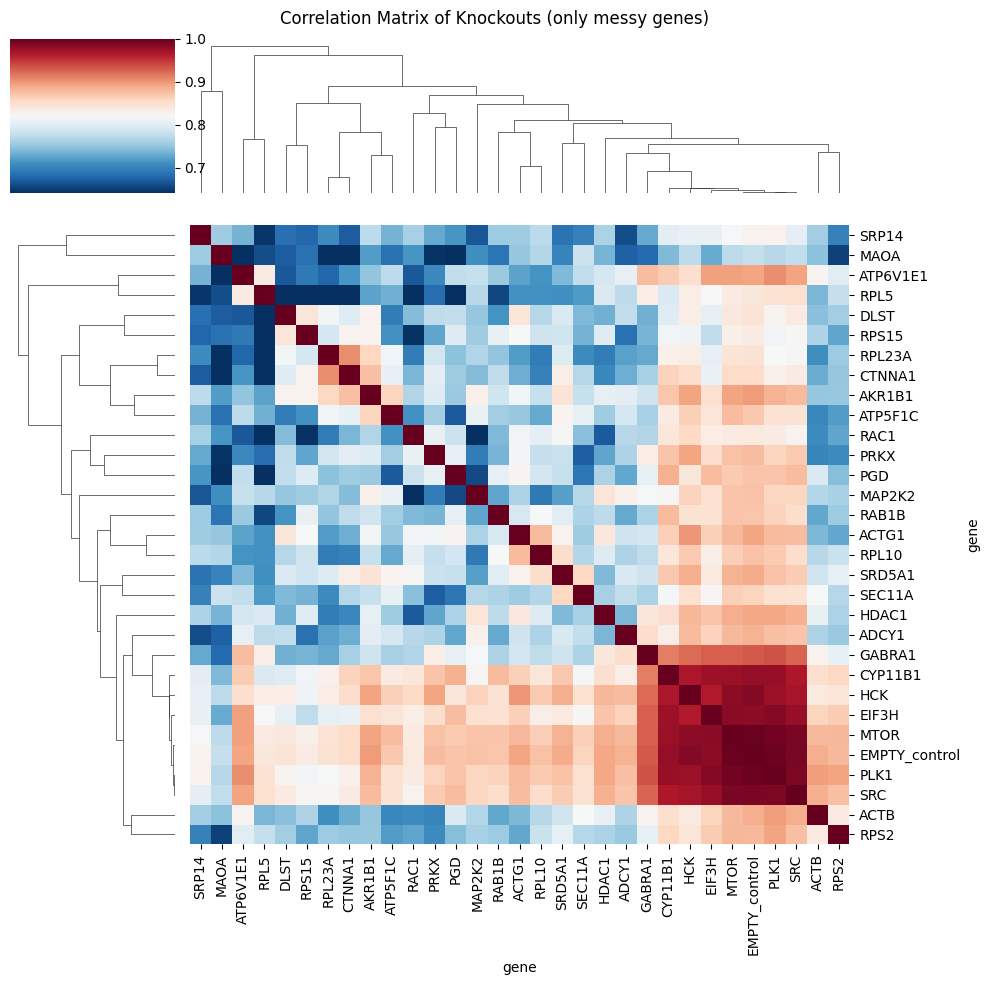

In [303]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def cosine_corr(df):
    # compute cosine similarity across columns
    cosine_sim = cosine_similarity(df.T)
    return pd.DataFrame(cosine_sim, index=df.columns, columns=df.columns)

# hypothesis: the genes that are causing noise in the correlation matrix are the ones rxrx did >2 experiments on
messy_genes = [
    'MTOR', 'ACTB', 'ATP6V1E1', 'EIF3H', 'DLST', 'PLK1', 
    'SRC', 'RAC1', 'RPL23A', 'AKR1B1', 'GABRA1', 'SRD5A1', 
    'PRKX', 'HCK', 'HDAC1', 'RPS15', 'CYP11B1', 'ATP5F1C', 
    'MAP2K2', 'CTNNA1', 'SEC11A', 'PGD', 'ADCY1', 'SRP14', 
    'MAOA', 'ACTG1', 'RAB1B', 'RPS2', 'RPL10', 'RPL5']
messiest_genes = ['MTOR', 'EIF3H', 'PLK1', 'SRC', 'HCK', 'CYP11B1']

data = rxrx3_adata_named_genes_mean[messy_genes + ['EMPTY_control'], :].to_df().T.corr()
g = sns.clustermap(
    data=data,
    metric='cosine',
    cmap='RdBu_r',
    robust=True,
    figsize=(10, 10),
)

g.fig.suptitle('Correlation Matrix of Knockouts (only messy genes)')
g.fig.tight_layout()
g.fig.savefig('rxrx3_knockout_correlation_matrix_messy.png', dpi=300)


In [10]:
from efaar_benchmarking.benchmarking import known_relationship_benchmark
recall_thr_pairs = [(0.05, 0.95), (0.1, 0.9)]
min_req_entity_cnt = 20
benchmark_data_dir = '/home/ubuntu/EFAAR_benchmarking/efaar_benchmarking/benchmark_annotations'
# Aggregate PCA-TVN

map_data = aggregate(
    embeddings=all_embeddings_pre_agg["pca-tvn"],
    metadata=rxrx3_adata.obs,
    pert_col=pert_colname,
    keys_to_remove=all_controls,
)

metrics = known_relationship_benchmark(
    map_data=map_data, 
    pert_col=pert_colname,
    benchmark_sources=['StringDB'],  # Seeing if this solves the mem issue
    recall_thr_pairs=recall_thr_pairs,
    min_req_entity_cnt=min_req_entity_cnt,
    benchmark_data_dir=benchmark_data_dir,
    log_stats=True
)


/home/ubuntu/EFAAR_benchmarking/efaar_benchmarking/efaar.py:210: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouping = metadata.groupby(pert_col)


102703 perturbations exist in the map.


: 